In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import util
from util import *
from PIL import Image
from IPython.display import display

In [4]:
# code to read weights
import re

params = []
end_re = re.compile(r'^\[torch.CudaTensor of size (\w+)\]')
index_re = re.compile(r'^\((\d+),(\d+)')
with open('shapenet_intrinsics/train/model_weights_all.txt') as f:
    current = []
    linenum = 1
    for line in f:
        end = end_re.match(line)
        if end:
            end_dims = tuple(map(int, end.group(1).split('x')))
            if len(end_dims) == 1:
                if current[0].startswith('0.01 *'):
                    current = current[1:]
                array = np.array(tuple(map(float, current)))
                assert(len(array) == end_dims[0])
            else:
                array = np.zeros(end_dims)
                i = 0
                while i < len(current):
                    match = index_re.match(current[i])
                    first_index = int(match.group(1)) - 1
                    second_index = int(match.group(2)) - 1
                    for j in range(3):
                        array[first_index][second_index][j] = np.array(tuple(map(float, current[i + 1 + j].lstrip().split())))
                    i += 5
            params.append(array)
            current = []
            continue
        current.append(line)

In [17]:
# wrapper for applying spatial conv, batchnorm, reLU
def conv2d(x, W, b, stride):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
    # Batch Norm
    x = tf.contrib.layers.batch_norm(x, center=True, scale=True)
    return tf.nn.relu(x)

def deconv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
    # Batch Norm
    x = tf.contrib.layers.batch_norm(x, center=True, scale=True)
    x = tf.nn.relu(x)
    
    # bilinear interpolation upsampling
    old_height, old_width = x.get_shape().as_list()[1 : 3]
    scale = 2
    new_height = old_height * scale
    new_width = old_width * scale
    return tf.image.resize_images(x, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)

ENCODER = 'encoder'
MID = 'mid'
DECODER = 'decoder'

def get_dimension_name(stage, layer_num):
    return 'dims_' + stage + '_' + str(layer_num)

def get_weight_name(stage, layer_num):
    return 'w_' + stage + '_' + str(layer_num)
    
def get_bias_name(stage, layer_num):
    return 'b_' + stage + '_' + str(layer_num)

In [7]:
param_values = {}
layer_index = 0
for encoder_layer in range(6):
    weight_name = get_weight_name(ENCODER, encoder_layer)
    bias_name = get_bias_name(ENCODER, encoder_layer)
    param_values[weight_name] = params[layer_index]
    param_values[bias_name] = params[layer_index + 1]
    layer_index += 4

for branch in range(3):
    for mid_layer in range(4):
        weight_name = get_weight_name(MID, (branch, mid_layer))
        bias_name = get_bias_name(MID, (branch, mid_layer))
        param_values[weight_name] = params[layer_index]
        param_values[bias_name] = params[layer_index + 1]
        layer_index += 4

for decoder_layer in range(5):
    for branch in range(3):
        weight_name = get_weight_name(DECODER, (branch, decoder_layer))
        bias_name = get_bias_name(DECODER, (branch, decoder_layer))
        param_values[weight_name] = params[layer_index]
        param_values[bias_name] = params[layer_index + 1]
        layer_index += 4
        
for decoder_layer in range(5, 7):
    weight_name = get_weight_name(DECODER, decoder_layer)
    bias_name = get_bias_name(DECODER, decoder_layer)
    param_values[weight_name] = params[layer_index]
    param_values[bias_name] = params[layer_index + 1]
    layer_index += 4
param_values_32 = { name : np.moveaxis(value.astype(np.float32), (0, 1, 2, 3), (3, 2, 1, 0)) if len(value.shape) == 4 else value.astype(np.float32) for name, value in param_values.items() }

In [6]:
def load_dataset():
    delighted_data = {}
    for mesh, mesh_dir in delighted_dirs.items():
        mesh_im = Image.open(mesh_dir + '%s_HD_BC.tga' % mesh, 'r')
        mesh_im = mesh_im.resize((256, 256), Image.ANTIALIAS)
        mesh_array = zero_rgb(np.array(mesh_im))
        mesh_array = mesh_array[:,:,:3]        
        delighted_data[mesh] = mesh_array

    lighted_data = []
    for t, mesh, v, mesh_dir in lighted_dirs:
        lit_file = '%s%s_%s_%s_Lit.tga' % (mesh_dir, t, mesh, v)
        if not os.path.exists(lit_file):
            continue
        mesh_im = Image.open(lit_file, 'r')
        # resize according to shapenet
        mesh_im = mesh_im.resize((256, 256), Image.ANTIALIAS)
        meshes = np.array(mesh_im)[:,:,:3]
        lighted_data.append((mesh, meshes))
        
    return delighted_data, lighted_data

#unused method to scale from 0 to 1~ish
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    return temp_batch

def shuffle(Xtrain, ytrain):
    stacked = np.column_stack((Xtrain,ytrain))
    np.random.shuffle(stacked)
    return stacked[:,:Xtrain.shape[1]], stacked[:,Xtrain.shape[1]]

date_dir = ''
delighted_dirs, lighted_dirs = scan_lighted_delighted(date_dir)

delighted_data, lighted_data = load_dataset()

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [18]:
# Store layers weight & bias
# more parameters
FILTER_SIZE = 3
INPUT_DEPTH = 3

# output depths of the layers
ENCODER_DEPTHS = [16, 32, 64, 128, 256, 256]
MID_DEPTH = ENCODER_DEPTHS[-1]
DECODER_DEPTHS = [256, 128, 64, 32, 16, 16, 3]

# defines the sizes for each of the conv / deconv layers
layer_dimensions = {}
prev_depth = INPUT_DEPTH
for i, output_depth in enumerate(ENCODER_DEPTHS):
    weight_name = get_dimension_name(ENCODER, i)
    stride = 1 if i == 0 else 2 # stride 1 for the first conv layer only
    layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth

for j in range(3):
    for i in range(4):
        weight_name = get_dimension_name(MID, (j, i))
        layer_dimensions[weight_name] = {
            'input_depth' : MID_DEPTH,
            'output_depth' : MID_DEPTH,
            'stride' : 1,
            'filter_size' : FILTER_SIZE
        }

prev_depth = MID_DEPTH
for i, output_depth in enumerate(DECODER_DEPTHS):
    # the ith deconv layer's input is the concatenation of the previous output and the output of (5-i)th encoder conv layer
    # so the depth is the sum of the depths
    # the last two layers in this loop (5th and 6th layer) are conv layers, not deconv
    if i < 6:
        prev_encoder_depth = ENCODER_DEPTHS[5 - i]
        input_depth = 3 * prev_depth + prev_encoder_depth
    else: # 6th layer doesn't have concatenation
        input_depth = prev_depth
    value = {
        'input_depth' : input_depth,
        'output_depth' : output_depth,
        'stride' : 1,
        'filter_size' : FILTER_SIZE
    }
    if i < 5:
        for j in range(3):
            weight_name = get_dimension_name(DECODER, (j, i))
            layer_dimensions[weight_name] = value
    else:
        layer_dimensions[get_dimension_name(DECODER, i)] = value
    prev_depth = output_depth

In [19]:
class IntrinsicNetwork(object):
    def __init__(self, input_dimensions, dimensions, param_values, learning_rate=1e-3):
        graph = tf.Graph()
        self.sess = tf.InteractiveSession(graph=graph)
        
        self.dimensions = dimensions
        self.params = {}
        self.param_values = param_values
        
        # in the paper each input sample is 256x256x3
        self.inp = tf.placeholder(tf.float32, shape=[None,] + list(input_dimensions))
        self.expected_output = tf.placeholder(tf.float32, shape=[None,] + list(input_dimensions))
        
        encoder_layers = self.get_encoder_layers(self.inp)
        mid_outputs = self.get_mid_outputs(encoder_layers[-1])
        self.output = self.get_decoder_output(mid_outputs, encoder_layers)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.output, self.expected_output))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        saver = tf.train.Saver()
        saver.restore(self.sess, 'models/shape_intrinsic_original.ckpt')
#         init = tf.global_variables_initializer()
#         self.sess.run(init)
#         show_graph(graph.as_graph_def())
    
    def create_weights(self, stage, layer_num):
        dims = self.dimensions[get_dimension_name(stage, layer_num)]
        input_depth, output_depth, stride, filter_size = \
            (dims[x] for x in ['input_depth', 'output_depth', 'stride', 'filter_size'])
        weight_name = get_weight_name(stage, layer_num)
        bias_name = get_bias_name(stage, layer_num)
#         W = tf.Variable(self.param_values[weight_name])
#         b = tf.Variable(self.param_values[bias_name])
        W = tf.Variable(tf.random_normal([filter_size, filter_size, input_depth, output_depth]))
        b = tf.Variable(tf.random_normal([output_depth]))
        self.params[weight_name] = W
        self.params[bias_name] = b
        return W, b, stride
        
    def get_encoder_layers(self, input):
        prev = input
        encoder_layers = []
        # encoder layers 0 to 5
        for layer_num in range(6):
            W, b, stride = self.create_weights(ENCODER, layer_num)
            prev = conv2d(prev, W, b, stride)
            encoder_layers.append(prev)
        return encoder_layers
    
    def get_mid_outputs(self, encoder_output):
        mid_outputs = []
        for branch in range(3):
            prev = encoder_output
            for layer_num in range(4):
                W, b, stride = self.create_weights(MID, (branch, layer_num))
                prev = conv2d(prev, W, b, stride)
            mid_outputs.append(prev)
        return mid_outputs
    
    def get_decoder_output(self, mid_outputs, encoder_layers):
        prevs = mid_outputs
        for layer_num in range(5):
            encoder_layer_input = encoder_layers[5 - layer_num]
            prev = tf.concat(prevs + [encoder_layer_input], axis=3)
            new_branches = []
            for branch in range(3):
                W, b, stride = self.create_weights(DECODER, (branch, layer_num))
                # concatenate with encoder layer for layers 0 to 5                
                new_branch = deconv2d(prev, W, b, stride)
                new_branches.append(new_branch)
            prevs = new_branches
        for layer_num in range(5, 7):
            if layer_num == 5:
                merged = tf.concat(prevs + [encoder_layers[0]], axis=3)
            W, b, stride = self.create_weights(DECODER, layer_num)
            merged = conv2d(merged, W, b, stride)        
        return merged
    
    def fit_batch(self, inputs, output):
        _, loss = self.sess.run((self.optimizer, self.loss), feed_dict={self.inp : inputs, self.expected_output : output})
        return loss
    
    def train(self, lighted_inputs, delighted_data, epochs, batch_size=1, display_step=5):
        random.shuffle(lighted_inputs)
        n_samples = len(lighted_inputs)
        mean_losses = []
        for epoch in range(epochs):
            total_iter = n_samples // batch_size
            total_loss = 0
            for i in range(total_iter):
                meshes, inputs = zip(*lighted_inputs[i * batch_size : (i + 1) * batch_size])
                inputs = np.asarray(inputs)
                expected_outputs = np.asarray([delighted_data[mesh] for mesh in meshes])
                loss = self.fit_batch(inputs, expected_outputs)
                total_loss += loss
            mean_loss = total_loss / total_iter
            mean_losses.append(mean_loss)
            if (epoch + 1) % display_step == 0:
                print('epoch %s: loss=%.4f' % (epoch + 1, mean_loss))
                
    def predict(self, inputs):
        return self.sess.run(self.output, feed_dict={self.inp : inputs})

In [20]:
inet = IntrinsicNetwork((256, 256, INPUT_DEPTH), layer_dimensions, None)

Couldn't import dot_parser, loading of dot files will not be possible.
INFO:tensorflow:Restoring parameters from models/shape_intrinsic_original.ckpt


In [14]:
saver = tf.train.Saver()
saver.save(inet.sess, 'models/shape_intrinsic_original.ckpt')

'models/shape_intrinsic_original.ckpt'

In [ ]:
inet.train(lighted_data[50:], delighted_data, epochs=10, batch_size=20)

In [ ]:
Image.fromarray(lighted_data[0][1])

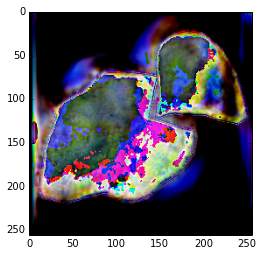

In [22]:
input = lighted_data[0][1]
plt.imshow((inet.predict(np.array([input])) * 255)[0].astype(np.uint8))
plt.show()